In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.integrate import odeint

In [128]:
# Parameters
V0 = 15000 # Vmax (V)
f = 1000 # Hz
d_gap = 0.0015 # 갭 간격 (m)
d_diel = 0.002 # 유전체 두께 (m)
eps_r = 10 # 유전체의 상대 유전율
eps0 = 8.854e-12  # 진공 유전율 (F/m)
Di = 0.003 # 유전체 내경 (m)
Davg = (Di + Di + d_diel)/2 # 유전체 평균 지름 (m)
h = 0.003 # 전극 두께
cEEDF = 2 # 1:maxwellian, 2:druyvestein
e = 1.602e-19  # 전자 전하량 (C)
me = 9.109e-31  # 전자 질량 (kg)

In [129]:
# Operation condtion
VF = 13.3 / 60 / 1000000 # m3/s
crossA = np.pi*((h+2*d_gap)**2-h**2)/4 # m2
Vx = VF/ crossA # m/s
print(Vx)

0.010453139472208436


In [130]:
# Time Domain
t = np.linspace(0, 200/f, 2000)
dt = t[1] - t[0]
dL = Vx * dt
print(dL)

1.0458368656536704e-06


In [131]:
# Voltage
def voltage(t):
    return V0 * np.sin(2*np.pi*f*t)

# Gap Voltage
def Vol_gap(V_applied, Q_diel):
    C_diel = eps0 * eps_r * (np.pi*Davg*dL) / d_diel
    return V_applied - Q_diel / C_diel

# Electric Field
def electric_field(V_gap):
    return V_gap / d_gap

In [132]:
# EEDF
def EEDF(energy, mean_energy):
    if cEEDF == 1:
        g = 1 # maxwellian
    elif cEEDF == 2:
        g = 2 # druyvestein
    else:
        g = 1.5 # 개인이 변경 가능

    gamma_1 = special.gamma(5/2/g)
    gamma_2 = special.gamma(3/2/g)

    beta1 = (gamma_1)**(3/2) * (gamma_2)**(-5/2)
    beta2 = (gamma_1) * (gamma_2)**(-1)

    return g * mean_energy**(-3/2) * beta1 * np.exp(-(energy * beta2 / mean_energy)**g)

C:\Users\USER\AppData\Local\Temp\ipykernel_29652\3430039425.py:69: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(model, y0, t, args=(voltage,))
C:\Users\USER\AppData\Local\Temp\ipykernel_29652\3430039425.py:26: RuntimeWarning: overflow encountered in scalar multiply
  return e * ne * mobility * E
c:\Python\Python312\Lib\site-packages\matplotlib\ticker.py:2119: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


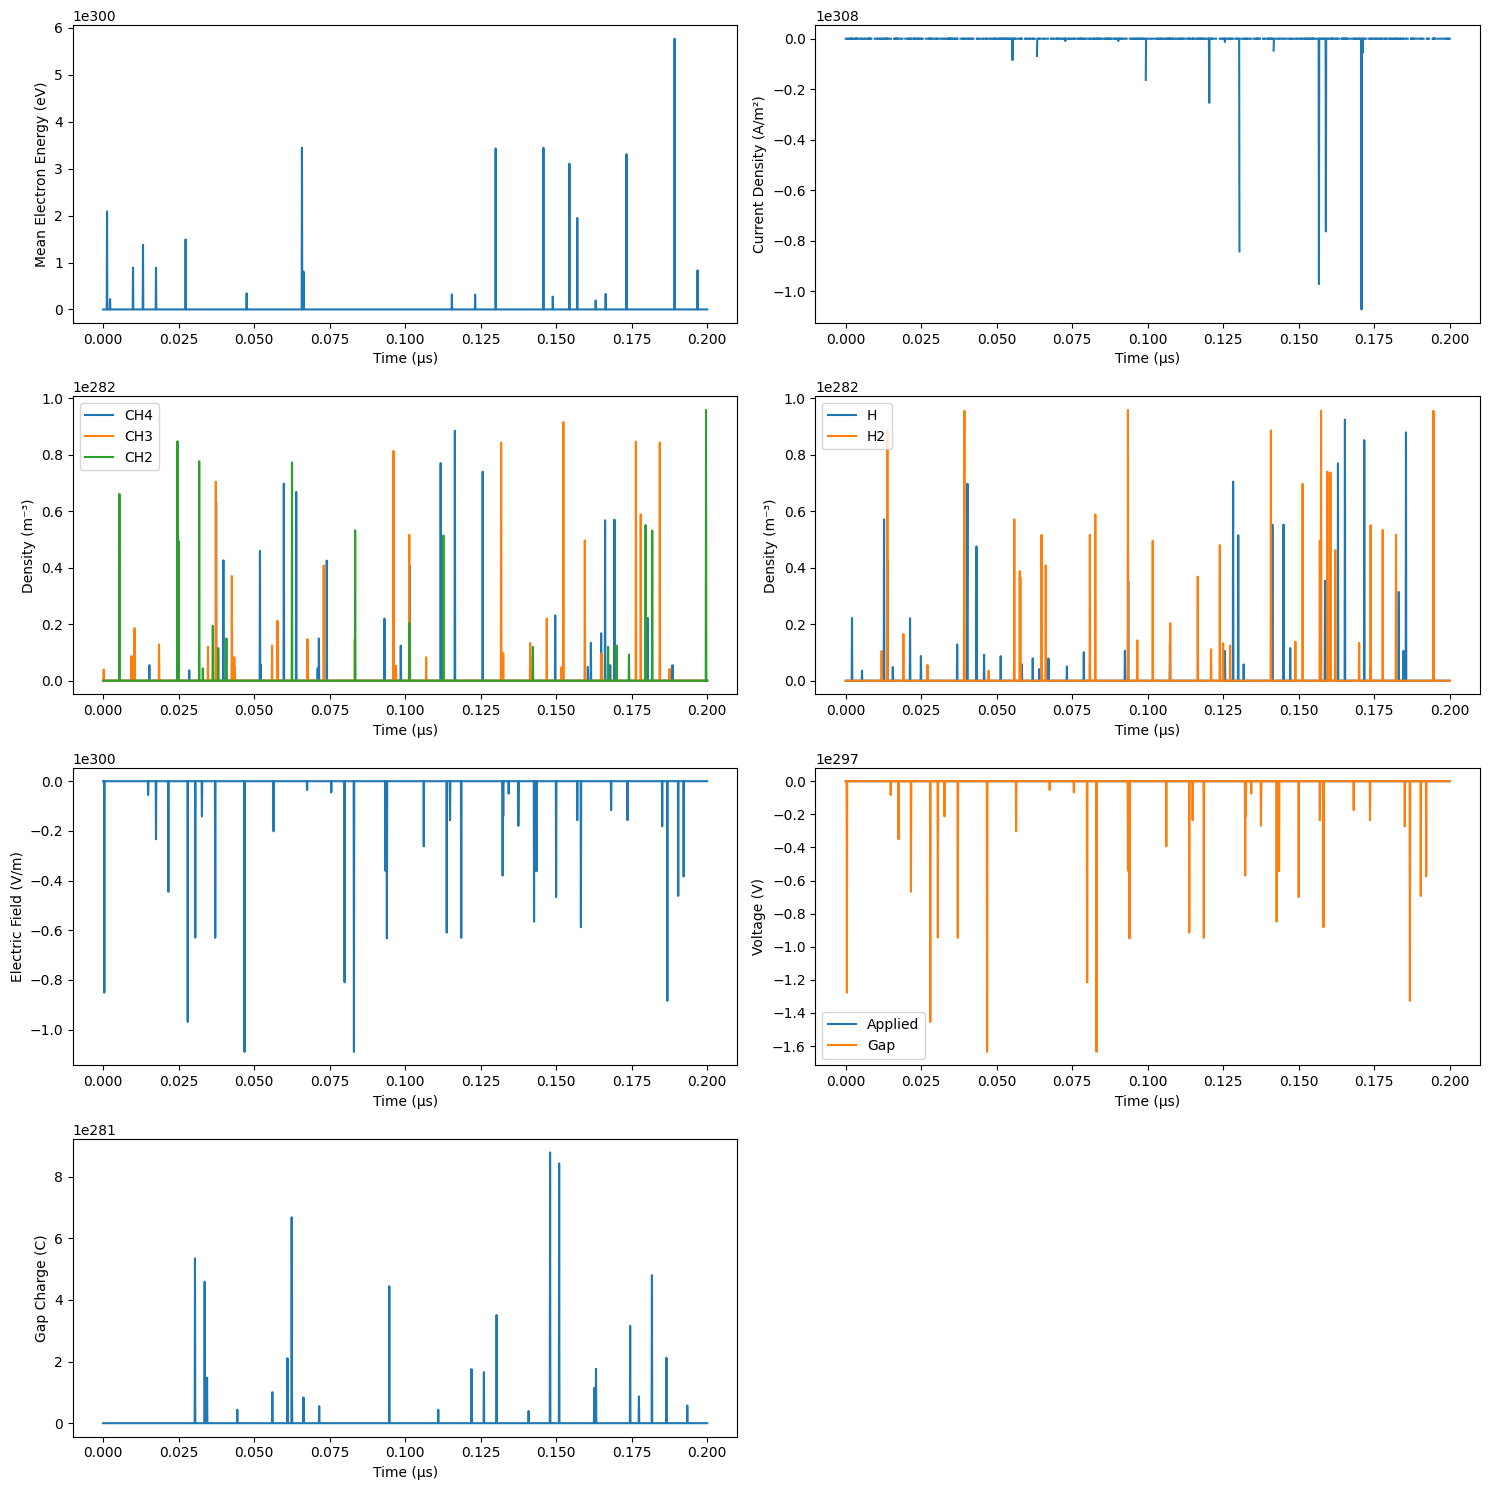

In [133]:
def calculate_mean_energy(old_mean_energy, E, ne, species_densities, dt):
    # Energy gain from electric field
    energy_gain = e * E * d_gap * dt / 3

    # 반응으로 인한 에너지 손실
    energy_loss = 0
    for reaction, data in reactions.items():
        rate = data['k'] * ne * species_densities[0]  # CH4 density
        energy_loss += rate * data['energy_loss'] * e * dt
    
    # 새로운 평균 에너지 계산
    new_energy = old_mean_energy + (energy_gain - energy_loss / ne)
    return max(new_energy, 1e-3 * e)  # 최소값 설정

# 반응 속도 상수 및 에너지 손실 (예시 값, 실제 값으로 대체 필요)
reactions = {
    'CH4 + e -> CH3 + H + e': {'k': 1e-20, 'energy_loss': 8.8},  # eV
    'CH4 + e -> CH2 + H2 + e': {'k': 5e-21, 'energy_loss': 10},  # eV
}

# 전류 밀도 계산 함수
def current_density(ne, E, mean_energy):
    # 전자 이동도를 평균 에너지의 함수로 가정
    #mobility = 0.036 * (mean_energy / e)**-0.5  # 예시 관계
    mobility = 4e24
    return e * ne * mobility * E

# 미분 방정식 시스템
def model(y, t, V_applied):
    ne, nCH4, nCH3, nCH2, nH, nH2, mean_energy, Q_gap = y
    species_densities = [nCH4, nCH3, nCH2, nH, nH2]
    
    # V_applied가 함수일 경우 현재 시간 t에 대한 값을 계산
    V_t = V_applied(t) if callable(V_applied) else V_applied
    
    V_gap = Vol_gap(V_t, Q_gap)
    E = electric_field(V_gap)
    
    # 반응률 계산
    rates = {name: data['k'] * ne * nCH4 for name, data in reactions.items()}
    
    dne_dt = 0  # 전자 밀도 변화 (여기서는 일정하다고 가정)
    dnCH4_dt = -sum(rates.values())
    dnCH3_dt = rates['CH4 + e -> CH3 + H + e']
    dnCH2_dt = rates['CH4 + e -> CH2 + H2 + e']
    dnH_dt = rates['CH4 + e -> CH3 + H + e']
    dnH2_dt = rates['CH4 + e -> CH2 + H2 + e']
    
    # 평균 전자 에너지 계산
    dt = 1e-7  # 고정된 시간 간격 사용
    new_energy = calculate_mean_energy(mean_energy, E, ne, species_densities, dt)
    denergy_dt = (new_energy - mean_energy) / dt
    
    # 갭의 전하량 변화
    J = current_density(ne, E, mean_energy)
    dQ_diel_dt = J * (np.pi*Davg*dL) / d_diel
    
    return [dne_dt, dnCH4_dt, dnCH3_dt, dnCH2_dt, dnH_dt, dnH2_dt, denergy_dt, dQ_diel_dt]

# 초기 조건
ne0 = 1e16  # 초기 전자 밀도 (m^-3)
nCH4_0 = 1e22  # 초기 CH4 밀도 (m^-3)
initial_energy = 1 * e  # 초기 평균 전자 에너지 (J)
Q_diel_0 = 0  # 초기 갭 전하량
y0 = [ne0, nCH4_0, 0, 0, 0, 0, initial_energy, Q_diel_0]  # [ne, nCH4, nCH3, nCH2, nH, nH2, mean_energy, Q_gap]

# 시뮬레이션 실행
V_applied = voltage(t)
solution = odeint(model, y0, t, args=(voltage,))

# 결과 추출
ne = solution[:, 0]
nCH4 = solution[:, 1]
nCH3 = solution[:, 2]
nCH2 = solution[:, 3]
nH = solution[:, 4]
nH2 = solution[:, 5]
mean_energies = solution[:, 6]
Q_diel = solution[:, 7]

# 갭 전압과 전기장 계산
V_gap = [Vol_gap(V, Q) for V, Q in zip(V_applied, Q_gap)]
E_field = [electric_field(V) for V in V_gap]

# 전류 밀도 계산
current_densities = [current_density(ne_t, E_t, energy_t) for ne_t, E_t, energy_t in zip(ne, E_field, mean_energies)]

# 결과 플롯
plt.figure(figsize=(15, 15))

plt.subplot(4, 2, 1)
plt.plot(t, np.array(mean_energies)/e)
plt.xlabel('Time (μs)')
plt.ylabel('Mean Electron Energy (eV)')

plt.subplot(4, 2, 2)
plt.plot(t, current_densities)
plt.xlabel('Time (μs)')
plt.ylabel('Current Density (A/m²)')

plt.subplot(4, 2, 3)
plt.plot(t, nCH4, label='CH4')
plt.plot(t, nCH3, label='CH3')
plt.plot(t, nCH2, label='CH2')
plt.xlabel('Time (μs)')
plt.ylabel('Density (m⁻³)')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(t, nH, label='H')
plt.plot(t, nH2, label='H2')
plt.xlabel('Time (μs)')
plt.ylabel('Density (m⁻³)')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(t, E_field)
plt.xlabel('Time (μs)')
plt.ylabel('Electric Field (V/m)')

plt.subplot(4, 2, 6)
plt.plot(t, V_applied, label='Applied')
plt.plot(t, V_gap, label='Gap')
plt.xlabel('Time (μs)')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(t, Q_diel)
plt.xlabel('Time (μs)')
plt.ylabel('Gap Charge (C)')

plt.tight_layout()
plt.show()